In [ ]:
import torch
import tqdm
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog

In [2]:
with initialize(config_path="./ynet_diffusion_config", version_base=None):
    new_diffusion_notebook_cfg = compose("ynet_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [4]:
one_batch = None
image_index = None
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_full_cat = TileCatalog(batch["tile_catalog"]).to_full_catalog(tile_slen)
    batch_plocs = batch_full_cat["plocs"]
    batch_plocs_mask = ((batch_plocs < 28.0) & (batch_plocs > 4.0)).all(dim=-1)
    batch_plocs_count = batch_plocs_mask.sum(dim=-1)
    if (batch_plocs_count >= 5).any():
        one_batch = batch
        image_index = (batch_plocs_count >= 5).nonzero()[0].item()
        break

  3%|▎         | 6/196 [00:04<02:33,  1.24it/s]


In [5]:
image_tile_cat = TileCatalog(one_batch["tile_catalog"])
image_full_cat = image_tile_cat.to_full_catalog(tile_slen)

In [6]:
image_plocs = image_full_cat["plocs"][image_index, :image_full_cat["n_sources"][image_index]]
image_plocs_mask = ((image_plocs < 28.0) & (image_plocs > 4.0)).all(dim=1)
image_plocs = image_plocs[image_plocs_mask]
assert image_plocs.shape[0] > 0

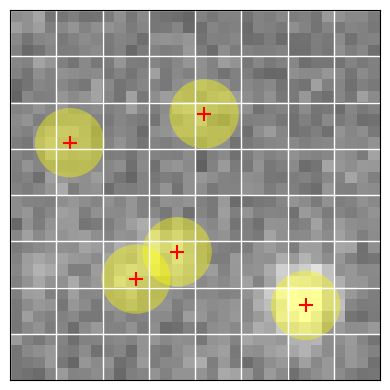

In [7]:
image = one_batch["images"][image_index, :, :32, :32]
image = ((image + 0.5).norm(dim=0, p=1) / 6).clamp(min=0, max=1)
image = (image * 255).clamp(min=0, max=255)

line_width = 1.0
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(image, cmap="gray", vmin=0, vmax=255)
for x in range(0, 32, 4):
    ax.axvline(x=x - 0.5, color="white", linewidth=line_width)
for y in range(0, 32, 4):
    plt.axhline(y=y - 0.5, color="white", linewidth=line_width)


for point in image_plocs:
    circle = plt.Circle((point[1], point[0]), radius=3, edgecolor=None, facecolor="yellow", alpha=0.4)
    ax.add_patch(circle)
ax.scatter(image_plocs[:, 1], image_plocs[:, 0], color="red", marker="+", s=100)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

In [15]:
image_n_sources = image_tile_cat["n_sources"][image_index][:8, :8]
n_sources_mask = (image_n_sources > 0) & (image_n_sources < 2)
boundary_mask = torch.ones((8, 8), dtype=torch.bool)
boundary_mask[[0, -1], :] = False
boundary_mask[:, [0, -1]] = False
n_sources_mask &= boundary_mask

In [ ]:
def generate_param_plot(param_values, n_sources_mask, only_show_int=False, tile_mask=None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    if tile_mask is None:
        ax.imshow(n_sources_mask, cmap="inferno")
    else:
        ax.imshow(torch.where(tile_mask, n_sources_mask, 0.5), cmap="inferno")
        n_sources_mask *= tile_mask

    line_width = 1.0
    for x in range(0, 8):
        ax.axvline(x=x - 0.5, color="white", linewidth=line_width)
    for y in range(0, 8):
        ax.axhline(y=y - 0.5, color="white", linewidth=line_width)

    for i in range(8):
        for j in range(8):
            value = param_values[i, j]
            if n_sources_mask[i, j]:
                text_color = "black"
                if not only_show_int:
                    ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                            color=text_color, fontsize=12, fontweight="bold")
                else:
                    ax.text(j, i, f"{int(value):.1e}", ha="center", va="center", 
                            color=text_color, fontsize=6, fontweight="bold")
            else:
                text_color = "white"
                ax.text(j, i, "0", ha="center", va="center", 
                        color=text_color, fontsize=12, fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()
    plt.show()

In [32]:
tile_mask = torch.tensor([[1, 0], [0, 1]]).bool().repeat(4, 4)

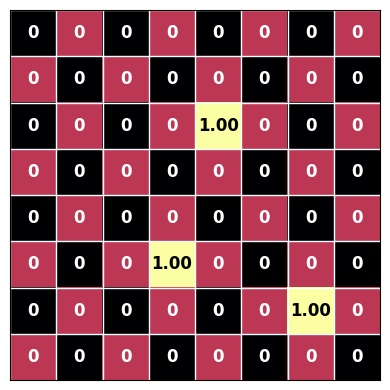

In [33]:
generate_param_plot(image_n_sources, n_sources_mask=n_sources_mask, tile_mask=tile_mask)

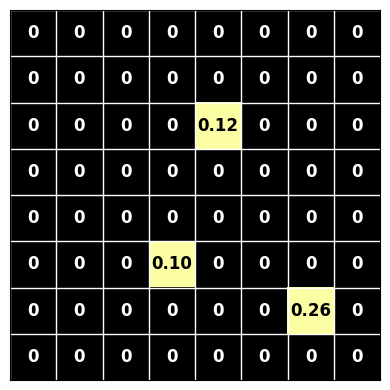

In [34]:
image_locs = image_tile_cat["locs"][image_index, :8, :8, 0, 0]
generate_param_plot(image_locs, n_sources_mask=n_sources_mask)

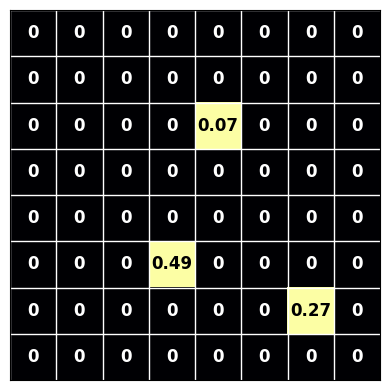

In [35]:
image_locs = image_tile_cat["locs"][image_index, :8, :8, 0, 1]
generate_param_plot(image_locs, n_sources_mask=n_sources_mask)

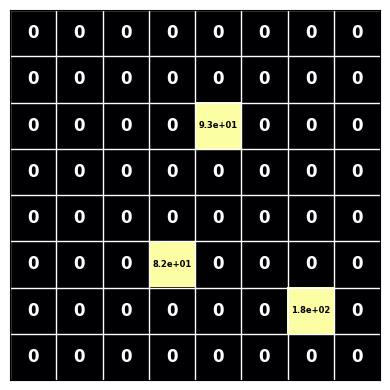

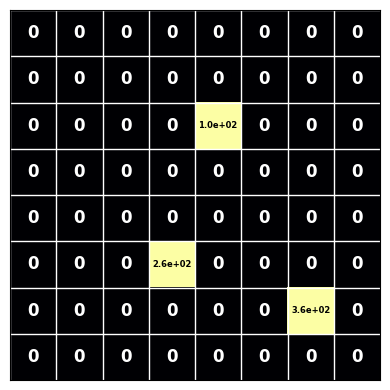

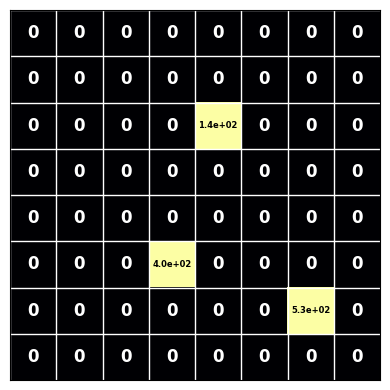

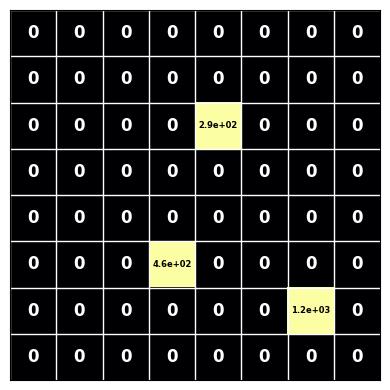

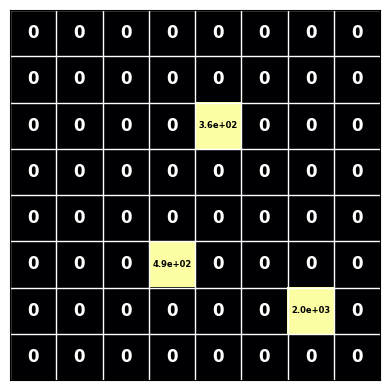

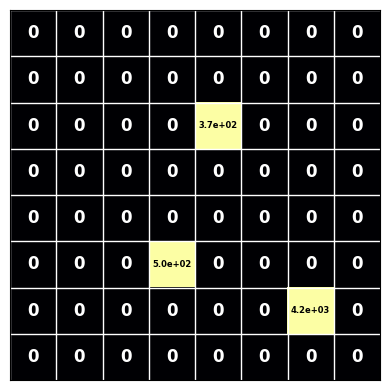

In [36]:
for i in range(6):
    image_flux = image_tile_cat["fluxes"][image_index, :8, :8, 0, i]
    generate_param_plot(image_flux, only_show_int=True, n_sources_mask=n_sources_mask)

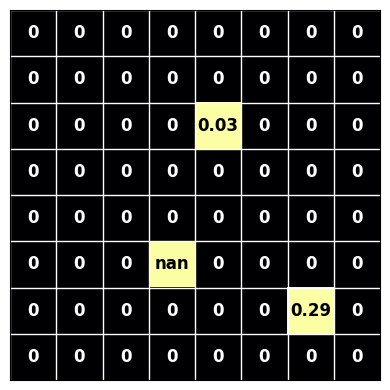

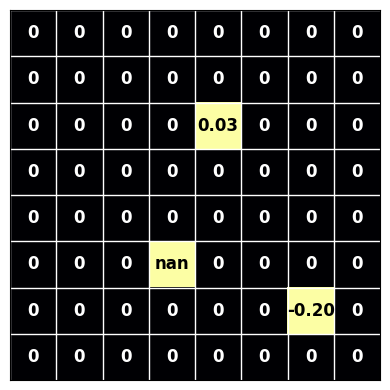

In [37]:
for i in range(2):
    ellip = image_tile_cat["ellipticity"][image_index, :8, :8, 0, i]
    generate_param_plot(ellip, n_sources_mask=n_sources_mask)

In [38]:
torch.save({
    "one_batch": one_batch,
    "image_index": image_index,
}, "visualize_one_batch.pt")